In [1]:
import torch
from torch.utils.data import DataLoader, Subset
from torch.nn import Sequential, Flatten, BatchNorm2d, BatchNorm1d, ReLU, LayerNorm, Dropout, AdaptiveAvgPool2d, LeakyReLU
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_, constant_, xavier_uniform_
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR
from torch.optim import Adam, SGD
from torcheval.metrics.functional import multiclass_accuracy 
from torchvision.datasets import ImageFolder
from torchvision import transforms


from pathlib import Path
from random import shuffle, seed

from flexai.modules import DenseLayer, ResLayer, ConvLayer
from flexai.learn import Learner
from flexai.mangers import ActivationStatsManger
from flexai.callbacks import LoggerCB, ForwardHookCB, MetricPlotterCB, TransformCB, LRFinderCB, LSUVCB, LRSchedulerCB
from flexai.vision.transforms import RandomNoise
from flexai.vision.display import show_batch

In [2]:
a = 43
torch.manual_seed(a)
seed(a)

In [3]:
data_path = Path('data')
paths = {'train': data_path/'train', 'test': data_path/'test'}

#(tensor([0.4810, 0.4350, 0.4097]), tensor([0.2525, 0.2573, 0.2610]))
# train_data_mean = [0.45, 0.45, 0.45]
# train_data_std = [0.25, 0.25, 0.25]

tfs = {
    'train': transforms.Compose([
        transforms.RandomPerspective(
            distortion_scale=0.2,
            p=0.1,
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=255
        ),
        transforms.RandomChoice([
            transforms.CenterCrop(15),
            transforms.CenterCrop(30),
            transforms.CenterCrop(45),
            transforms.Compose([
                transforms.CenterCrop(15),
                transforms.Grayscale(3),
            ]),
            transforms.Compose([
                transforms.CenterCrop(30),
                transforms.Grayscale(3),
            ])
        ]),
        RandomNoise(scales=[0.5, 0.5]),
        transforms.ColorJitter(hue=(0.1, 0.2)),
    ]),
    'valid':transforms.Compose([]),
    'test': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ]),
}

ds = ImageFolder(paths['train'], transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((512,512)),]))

idx_to_class = {v: k for k,v in ds.class_to_idx.items()}
indices = (list(range(len(ds))))
shuffle(indices)
size = int(len(indices) * 0.75)

datasets = {
    'train': Subset(ds, indices[:size]),
    'valid': Subset(ds, indices[size:]),
    'test': ImageFolder(paths['test'], transform=tfs['test']),
}

bs = 16

dls = {
    'train': DataLoader(datasets['train'], batch_size=bs, shuffle=False),
    'valid': DataLoader(datasets['valid'], batch_size=bs, shuffle=True),
    'test': DataLoader(datasets['test'], batch_size=1024, shuffle=False),
}



In [4]:
for phase in ['train', 'valid']:
    s, total = 0, 0
    for x, y in iter(dls[phase]):
        s += y.sum().item()
        total += len(y)
    print(s, total, s/total)

21 45 0.4666666666666667
8 16 0.5


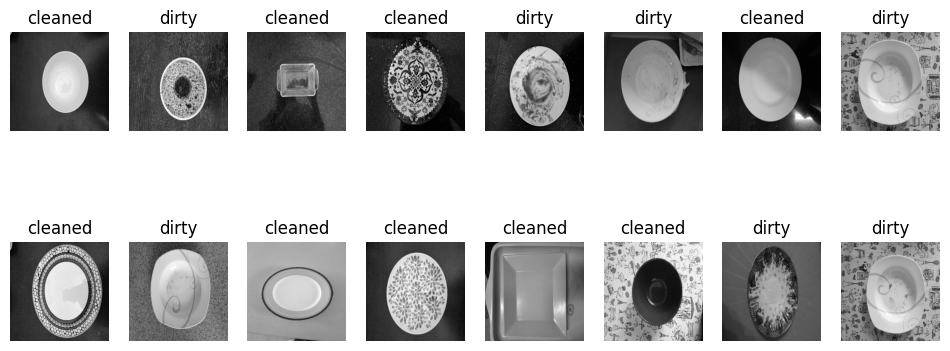

In [5]:
images, labels = next(iter(dls['train']))
show_batch(images, labels, idx_to_class, figsize=(12,5))

In [6]:
def res_init_func(w, b):
    kaiming_uniform_(w, 0.1)
    constant_(b, 0.1)

def linear_init_func(w,b):
    kaiming_uniform_(w, 0.1)
    constant_(b, 0.1)

def output_init_func(w, b):
    xavier_uniform_(w)
    constant_(b, 0)

def i_f(w, b):
    return

def resblock(in_c, out_c, ks=(3,3), stride=2, padding=1, bias=True, act=ReLU(), batch_norm=False, init_func=res_init_func):
    return ResLayer(in_c, out_c, ks, stride, padding, act=act, bias=bias, batch_norm=batch_norm, init_func=init_func)

def linearblock(in_f, out_f, act=ReLU(),norm=BatchNorm1d, bias=True, init_func=linear_init_func):
    if norm: norm = norm(out_f)
    return DenseLayer(in_f, out_f, act=act, norm=norm, bias=bias, init_func=init_func)



model = Sequential(
    BatchNorm2d(3),
    ResLayer(3, 16 , act=LeakyReLU(0.1), init_func=res_init_func),      #224
    ResLayer(16, 32, act=LeakyReLU(0.1), init_func=res_init_func),      #112
    ResLayer(32, 32, act=LeakyReLU(0.1), init_func=res_init_func),      #56
    ResLayer(32, 64, act=LeakyReLU(0.1), init_func=res_init_func),      #28
    ResLayer(64, 64, act=LeakyReLU(0.1), init_func=res_init_func),     #14
    ResLayer(64, 128, act=LeakyReLU(0.1), init_func=res_init_func),     #7
    ResLayer(128, 256, act=LeakyReLU(0.1), init_func=res_init_func),    #4
    ResLayer(256, 256, act=LeakyReLU(0.1), init_func=res_init_func),   #2
    ResLayer(256, 512, act=LeakyReLU(0.1), init_func=res_init_func),   #2
    Flatten(),
    Dropout(),
    DenseLayer(512, 2, act=None, init_func=output_init_func),
)

metrics = {'loss': CrossEntropyLoss(), 'acc': multiclass_accuracy}
optimizer = SGD(model.parameters(), lr=1e-4, weight_decay=0.1)

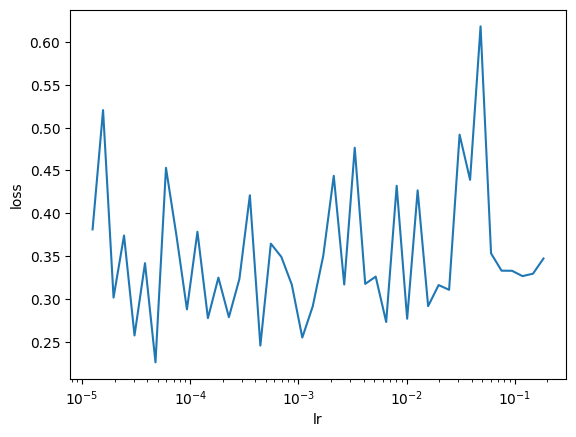

In [7]:
lr_find_scheduler = ExponentialLR(optimizer, gamma=1.25)
lr_find_learner = Learner(
    model,
    dls,
    optimizer,
    metrics,
    cbs=[
        LRFinderCB(lr_find_scheduler, start_lr=1e-5, max_lr=2, smooth_f=0.1, break_f=5, xscale='log'),
        TransformCB(transform=tfs['train'], phase='train'),
        LSUVCB(verbose=False),
    ]
)
lr_find_learner.fit(epochs=15, valid=False)

In [8]:
lr = 1e-2
for g in optimizer.param_groups:
    g['lr'] = lr

epochs = 10
iters = epochs * len(dls['train'])
scheduler = OneCycleLR(optimizer, lr, iters)

In [9]:
astatManger = ActivationStatsManger(model, type_filter=['ResLayer', 'DenseLayer'])

callbacks = [
    LoggerCB(), 
    ForwardHookCB(astatManger.register_stats),
    MetricPlotterCB(figsize=(10,4)),
    TransformCB(transform=tfs['train'], phase='train'),
    TransformCB(transform=tfs['valid'], phase='valid'),
    LSUVCB(),
    LRSchedulerCB(scheduler),
]
learner = Learner(model, dls, optimizer, metrics, cbs=callbacks)

Epoch: 1 | loss_train: 0.817 | loss_valid: 0.9738 | acc_train: 0.5288 | acc_valid: 0.5
Epoch: 2 | loss_train: 1.03 | loss_valid: 0.7427 | acc_train: 0.5753 | acc_valid: 0.5
Epoch: 3 | loss_train: 1.003 | loss_valid: 0.6961 | acc_train: 0.4872 | acc_valid: 0.5
Epoch: 4 | loss_train: 0.6825 | loss_valid: 0.6826 | acc_train: 0.5481 | acc_valid: 0.625
Epoch: 5 | loss_train: 0.6799 | loss_valid: 0.6844 | acc_train: 0.5128 | acc_valid: 0.5
Epoch: 6 | loss_train: 0.6611 | loss_valid: 0.6977 | acc_train: 0.6058 | acc_valid: 0.5
Epoch: 7 | loss_train: 0.6407 | loss_valid: 0.715 | acc_train: 0.5128 | acc_valid: 0.5
Epoch: 8 | loss_train: 0.7079 | loss_valid: 0.712 | acc_train: 0.4824 | acc_valid: 0.5
Epoch: 9 | loss_train: 0.6686 | loss_valid: 0.702 | acc_train: 0.6538 | acc_valid: 0.5
Epoch: 10 | loss_train: 0.6602 | loss_valid: 0.7013 | acc_train: 0.4984 | acc_valid: 0.5


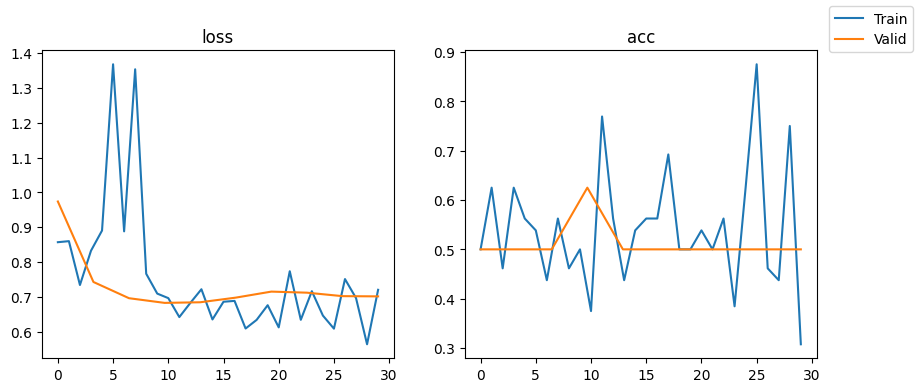

In [10]:
callbacks[-1] = LRSchedulerCB(scheduler)
learner.fit(epochs)

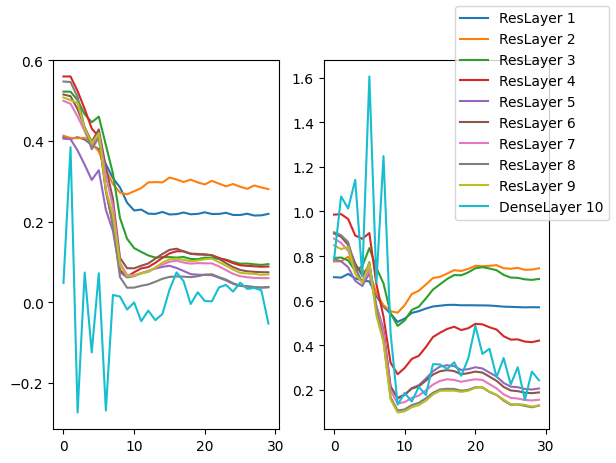

In [11]:
astatManger.mean_std()

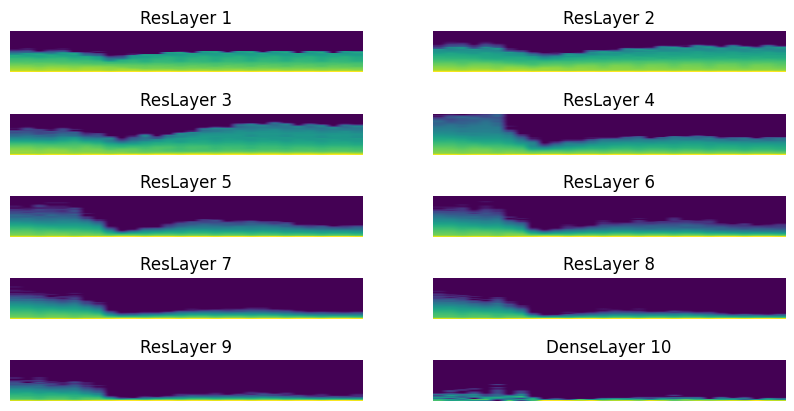

In [12]:
astatManger.color_dim()

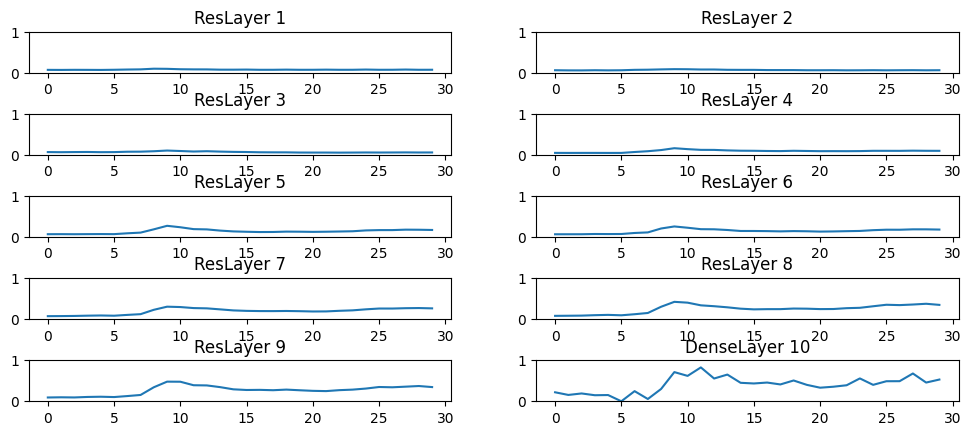

In [13]:
astatManger.dead_chart()

In [14]:
tta =  [
    transforms.CenterCrop(200),
    transforms.CenterCrop(180),
    transforms.Compose([
        transforms.CenterCrop(220),
        transforms.Grayscale(3),
    ])
]

In [15]:
accs = []
for images, labels in dls['valid']:
    results = []
    for t in tta:
        logst = model(t(images))
        logst = logst / logst.abs().sum(dim=1, keepdim=True)
        results.append(logst)
    logst = torch.stack(results).sum(dim=0)
    accs.append(metrics['acc'](logst, labels).item())

print(sum(accs)/len(accs))


0.5


In [16]:
# labels = []
# for images, _ in dls['test']:
#     results = []
#     for t in tta:
#         logst = model(t(images))
#         logst = logst / logst.abs().sum(dim=1, keepdim=True)
#         results.append(logst)
#     logst = torch.stack(results).sum(dim=0)
#     preds = logst.argmax(dim=1)
#     labels += preds
#     list(map(lambda x: x.item(), labels))